In [1]:
import torch
import numpy as np
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data and Model Preparation

In [2]:
nr_samples = 100
dataset = torch.rand((nr_samples, 2))
labels_dataset = torch.sum(torch.square(dataset - torch.tensor([.5, .5])), dim=1) < .09

In [3]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]
            yield data, labels
            
train_labels = torch.tensor(labels_dataset[:50], dtype=torch.float32)
test_labels = torch.tensor(labels_dataset[50:],  dtype=torch.float32)

train_loader = DataLoader(dataset[:50], train_labels, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[50:], test_labels, batch_size=64, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_55619/118873506.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(labels_dataset[:50], dtype=torch.float32)
/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_55619/118873506.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(labels_dataset[50:],  dtype=torch.float32)


In [4]:
import torch.nn as nn 

class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.elu = nn.ELU()
        self.layer1 = nn.Linear(2, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 1)  # Output a single value per input
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        logits = self.layer3(x)
        probs = self.sigmoid(logits)
        return probs

    def predict(self, x):
        probs = self.forward(x)
        preds = (probs > 0.49999).float()
        return preds

    def compute_accuracy(self, data_loader):
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in data_loader:
                preds = self.predict(data)
                predicted_labels = preds.squeeze()
                true_labels = labels.float()
                correct += (predicted_labels == true_labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        return accuracy

## My Implementation 

In [5]:
a = ModelA() 
a.compute_accuracy(train_loader)

0.22

In [6]:
a.compute_accuracy(test_loader)

0.22

In [7]:
loaders = [LoaderWrapper(loader=train_loader, variables=["x"], targets=["y"])]

predicates = {
    "Classifier": a
}

constant_mapping = {
    "pos": torch.tensor([1.]),
    "neg": torch.tensor([0.])
}

kb = KnowledgeBase("binary_config.yaml", predicates, loaders, constant_mapping)

In [8]:
kb.predicates

{'Classifier': ModelA(
   (elu): ELU(alpha=1.0)
   (layer1): Linear(in_features=2, out_features=16, bias=True)
   (layer2): Linear(in_features=16, out_features=16, bias=True)
   (layer3): Linear(in_features=16, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 )}

In [9]:
kb.rules

[∀ x.(((y == pos) -> Classifier(x))), ∀ x.(((y == neg) -> ~(Classifier(x))))]

In [10]:
kb.rule_to_data_loader_mapping

{∀ x.(((y == pos) -> Classifier(x))): [ <Loader>:(['x'] -> ['y']),
   <Loader>:(['x'] -> ['y'])],
 ∀ x.(((y == neg) -> ~(Classifier(x)))): [ <Loader>:(['x'] -> ['y']),
   <Loader>:(['x'] -> ['y'])]}

In [11]:
kb.optimize(num_epochs=2001, log_steps=500)

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.5735, grad_fn=<RsubBackward1>), tensor(0.4750, grad_fn=<RsubBackward1>)]
Epoch 1/2001, Loss: 0.47826921939849854

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.4665, grad_fn=<RsubBackward1>), tensor(0.8181, grad_fn=<RsubBackward1>)]
Epoch 501/2001, Loss: 0.3985416293144226

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.4788, grad_fn=<RsubBackward1>), tensor(0.8079, grad_fn=<RsubBackward1>)]
Epoch 1001/2001, Loss: 0.3927980661392212

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.5991, grad_fn=<RsubBackward1>), tensor(0.7545, grad_fn=<RsubBackward1>)]
Epoch 1501/2001, Loss: 0.3323928117752075

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.6187

In [12]:
a.compute_accuracy(train_loader)

1.0

In [13]:
a.compute_accuracy(test_loader)

0.98

## Computation Graph

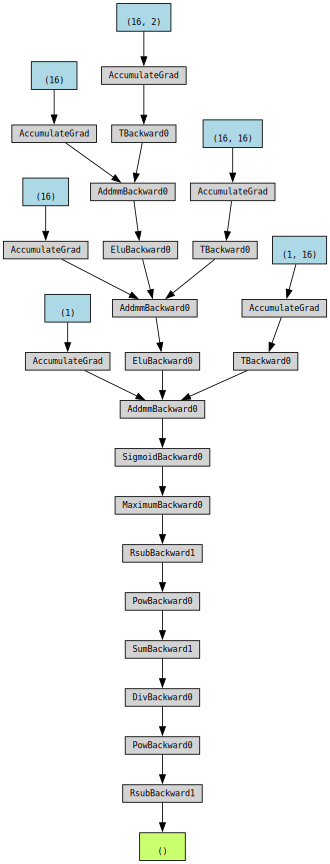

In [14]:
batch = next(iter(test_loader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loaders[0])

kb.rules[0].comp_graph(var_mapping)